In [ ]:
import json
data_path = "/content/qrecc-training.json"

with open(data_path, "r") as f:
    qrecc_data = json.load(f)

print(f" Loaded {len(qrecc_data)} conversations from QReCC dataset.\n")
print(json.dumps(qrecc_data[0], indent=2))


 Loaded 63501 conversations from QReCC dataset.

{
  "Context": [],
  "Question": "What can you tell me about Gary Cherone?",
  "Rewrite": "What can you tell me about Gary Cherone?",
  "Answer": "Gary Francis Caine Cherone is an American rock singer and songwriter, known for his work as the lead vocalist of Extreme and for his short stint for Van Halen.",
  "Answer_URL": "https://en.wikipedia.org/wiki/Van_Halen",
  "Conversation_no": 1,
  "Turn_no": 1,
  "Conversation_source": "quac"
}


In [ ]:
# =======================
# STEP 2 : Compute Teacher Scores (Selective Distillation)
# =======================
import json, torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# ----- Load QReCC dataset -----
data_path = "/content/qrecc-training.json"
with open(data_path, "r") as f:
    qrecc_data = json.load(f)

print(f"Loaded {len(qrecc_data)} conversations from QReCC.")
print("Sample keys:", list(qrecc_data[0].keys()))

# ----- Load Teacher Models -----
teacher_q_encoder = AutoModel.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
teacher_ctx_encoder = AutoModel.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")
teacher_tokenizer = AutoTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_q_encoder.to(device)
teacher_ctx_encoder.to(device)

# ----- Define Scoring Function -----
def get_teacher_score(query, passage):
    if not query or not passage:
        return 0.0

    q_inputs = teacher_tokenizer(query, return_tensors='pt', truncation=True, padding=True).to(device)
    d_inputs = teacher_tokenizer(passage, return_tensors='pt', truncation=True, padding=True).to(device)

    with torch.no_grad():
        q_emb = teacher_q_encoder(**q_inputs).pooler_output
        d_emb = teacher_ctx_encoder(**d_inputs).pooler_output

    if q_emb is None or d_emb is None:
        return 0.0

    score = F.cosine_similarity(q_emb, d_emb).item()
    return score

# ----- Compute Scores -----
teacher_scored_data = []
limit = 100  # Increase this later (e.g., len(qrecc_data)) for full run

for sample in tqdm(qrecc_data[:limit], desc="Scoring with teacher model"):
    query = sample.get("Rewrite", "").strip()
    # Use 'Context' and 'Answer' as pseudo-passages
    passages = []
    if isinstance(sample.get("Context"), str):
        passages.append(sample["Context"])
    if isinstance(sample.get("Answer"), str):
        passages.append(sample["Answer"])

    for passage in passages:
        score = get_teacher_score(query, passage)
        teacher_scored_data.append({
            "query": query,
            "doc": passage,
            "teacher_score": score
        })

print(f"\nGenerated teacher scores for {len(teacher_scored_data)} query–document pairs.")
if teacher_scored_data:
    print("Sample entry:\n", teacher_scored_data[0])
else:
    print("No teacher scores were generated — check dataset fields or increase `limit`.")


Loaded 63501 conversations from QReCC.
Sample keys: ['Context', 'Question', 'Rewrite', 'Answer', 'Answer_URL', 'Conversation_no', 'Turn_no', 'Conversation_source']


config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of DPRQuestionEncoder were not initialized from the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base and are newly initialized: ['question_encoder.bert_model.embeddings.LayerNorm.bias', 'question_encoder.bert_model.embeddings.LayerNorm.weight', 'question_encoder.bert_model.embeddings.position_embeddings.weight', 'question_encoder.bert_model.embeddings.token_type_embeddings.weight', 'question_encoder.bert_model.embeddings.word_embeddings.weight', 'question_encoder.bert_model.encoder.layer.0.attention.output.LayerNorm.bias', 'question_encoder.bert_model.encoder.layer.0.attention.output.LayerNorm.weight', 'question_encoder.bert_model.encoder.layer.0.attention.output.dense.bias', 'question_encoder.bert_model.encoder.layer.0.attention.output.dense.weight', 'question_encoder.bert_model.encoder.layer.0.attention.self.key.bias', 'question_encoder.bert_model.encoder.layer.0.attention.self.key.weight', 'question_encoder.bert_model.encoder.layer.0.attention.self.query.bias

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Scoring with teacher model: 100%|██████████| 100/100 [00:02<00:00, 45.44it/s]


Generated teacher scores for 100 query–document pairs.
Sample entry:
 {'query': 'What can you tell me about Gary Cherone?', 'doc': 'Gary Francis Caine Cherone is an American rock singer and songwriter, known for his work as the lead vocalist of Extreme and for his short stint for Van Halen.', 'teacher_score': -0.028228018432855606}


In [ ]:
# =======================
# STEP 3 : Select High-Confidence Samples (Selective Filtering)
# =======================

import json
import pandas as pd

# Threshold for teacher confidence (tune as needed)
threshold = 0.0

# Filter out low-confidence pairs
selected_data = [item for item in teacher_scored_data if item['teacher_score'] >= threshold]

print(f"Selected {len(selected_data)} of {len(teacher_scored_data)} pairs (threshold={threshold})")

# Show a few selected examples
for ex in selected_data[:3]:
    print("\nQuery:", ex["query"])
    print("Doc:", ex["doc"][:120], "...")
    print("Teacher Score:", round(ex["teacher_score"], 4))

# Save selected subset for student training
output_path = "/content/selected_qrecc_sd.json"
with open(output_path, "w") as f:
    json.dump(selected_data, f, indent=2)

print(f"\nSaved selected data to: {output_path}")

# View score distribution summary
if teacher_scored_data:
    df = pd.DataFrame(teacher_scored_data)
    print("\nScore Distribution Summary:")
    print(df["teacher_score"].describe())
else:
    print("\nNo teacher scores were generated — check dataset fields or increase `limit`.")

Selected 3 of 100 pairs (threshold=0.0)

Query: How did Van Halen reunite with David Lee Roth?
Doc: David Lee Roth called Eddie Van Halen to discuss what tracks would be included on a planned Van Halen compilation. Short ...
Teacher Score: 0.0006

Query: Where did Ralph Waldo Emerson finally settle?
Doc: Ralph Waldo Emerson then went farther south, to St. Augustine, Florida, where he took long walks on the beach and began  ...
Teacher Score: 0.0001

Query: Did The Animals release any albums?
Doc: The Animals also came out with albums such as Eric Is Here, Winds of Change, The Twain Shall Meet, and other albums. ...
Teacher Score: 0.0026

Saved selected data to: /content/selected_qrecc_sd.json

Score Distribution Summary:
count    100.000000
mean      -0.028601
std        0.018013
min       -0.088225
25%       -0.041504
50%       -0.025594
75%       -0.016663
max        0.002629
Name: teacher_score, dtype: float64


In [ ]:
# =======================
# STEP 4 : Train Student Model (Selective Distillation)
# =======================

import json, torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from tqdm import tqdm
import torch.nn.functional as F
import os

# ----- Load Selected (High-Confidence) Data -----
data_path = "/content/selected_qrecc_sd.json"
with open(data_path, "r") as f:
    selected_data = json.load(f)

print(f"Loaded {len(selected_data)} filtered query–document pairs for student training.")

# ----- Handle Empty Dataset -----
if len(selected_data) == 0:
    print("No data found in selected_qrecc_sd.json — using small synthetic fallback dataset for testing.")
    selected_data = [
        {"query": "Who is Elon Musk?", "doc": "Elon Musk is the CEO of Tesla and SpaceX."},
        {"query": "Where is the Eiffel Tower?", "doc": "The Eiffel Tower is in Paris, France."},
        {"query": "What is machine learning?", "doc": "Machine learning is a subfield of artificial intelligence."},
        {"query": "Who wrote Harry Potter?", "doc": "Harry Potter was written by J.K. Rowling."}
    ]

# ----- Define Dataset Class -----
class SDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        query_enc = self.tokenizer(
            item["query"], return_tensors="pt", padding="max_length",
            truncation=True, max_length=self.max_len
        )
        doc_enc = self.tokenizer(
            item["doc"], return_tensors="pt", padding="max_length",
            truncation=True, max_length=self.max_len
        )
        query_enc = {k: v.squeeze(0) for k, v in query_enc.items()}
        doc_enc = {k: v.squeeze(0) for k, v in doc_enc.items()}
        return query_enc, doc_enc

# ----- Initialize Student Model -----
model_name = "distilbert-base-uncased"
student_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model.to(device)

# ----- Create DataLoader -----
dataset = SDataset(selected_data, tokenizer)
if len(dataset) == 0:
    raise ValueError("Dataset is empty. Check your filtering threshold in Step 3.")

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: list(zip(*x)))

# ----- Optimizer -----
optimizer = AdamW(student_model.parameters(), lr=3e-5)

# ----- Training Loop -----
epochs = 100
student_model.train()

for epoch in range(epochs):
    total_loss = 0.0
    for q_batch, d_batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        q_inputs = {k: torch.stack([item[k] for item in q_batch]).to(device) for k in q_batch[0]}
        d_inputs = {k: torch.stack([item[k] for item in d_batch]).to(device) for k in d_batch[0]}

        q_emb = student_model(**q_inputs).last_hidden_state[:, 0, :]
        d_emb = student_model(**d_inputs).last_hidden_state[:, 0, :]

        q_emb = F.normalize(q_emb, p=2, dim=1)
        d_emb = F.normalize(d_emb, p=2, dim=1)

        scores = torch.matmul(q_emb, d_emb.T)
        labels = torch.arange(scores.size(0)).to(device)
        loss = F.cross_entropy(scores, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Average Loss: {avg_loss:.4f}")

# ----- Save Trained Student Model -----
save_path = "/content/student_model_sd"
os.makedirs(save_path, exist_ok=True)
student_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"Student model saved to: {save_path}")


Loaded 0 filtered query–document pairs for student training.
No data found in selected_qrecc_sd.json — using small synthetic fallback dataset for testing.


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Epoch 1/100: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Epoch 1 | Average Loss: 1.3568


Epoch 2/100: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Epoch 2 | Average Loss: 1.3141


Epoch 3/100: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


Epoch 3 | Average Loss: 1.2595


Epoch 4/100: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Epoch 4 | Average Loss: 1.1291


Epoch 5/100: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch 5 | Average Loss: 1.0295


Epoch 6/100: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


Epoch 6 | Average Loss: 0.9688


Epoch 7/100: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


Epoch 7 | Average Loss: 0.9172


Epoch 8/100: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


Epoch 8 | Average Loss: 0.8874


Epoch 9/100: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


Epoch 9 | Average Loss: 0.8292


Epoch 10/100: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


Epoch 10 | Average Loss: 0.8038


Epoch 11/100: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch 11 | Average Loss: 0.7902


Epoch 12/100: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Epoch 12 | Average Loss: 0.7748


Epoch 13/100: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


Epoch 13 | Average Loss: 0.7503


Epoch 14/100: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Epoch 14 | Average Loss: 0.7295


Epoch 15/100: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


Epoch 15 | Average Loss: 0.7351


Epoch 16/100: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


Epoch 16 | Average Loss: 0.7506


Epoch 17/100: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


Epoch 17 | Average Loss: 0.6998


Epoch 18/100: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


Epoch 18 | Average Loss: 0.7054


Epoch 19/100: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch 19 | Average Loss: 0.7030


Epoch 20/100: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Epoch 20 | Average Loss: 0.6759


Epoch 21/100: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


Epoch 21 | Average Loss: 0.6734


Epoch 22/100: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


Epoch 22 | Average Loss: 0.6616


Epoch 23/100: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


Epoch 23 | Average Loss: 0.6605


Epoch 24/100: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


Epoch 24 | Average Loss: 0.6531


Epoch 25/100: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch 25 | Average Loss: 0.6581


Epoch 26/100: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch 26 | Average Loss: 0.6692


Epoch 27/100: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch 27 | Average Loss: 0.6483


Epoch 28/100: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


Epoch 28 | Average Loss: 0.6840


Epoch 29/100: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


Epoch 29 | Average Loss: 0.6415


Epoch 30/100: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


Epoch 30 | Average Loss: 0.6381


Epoch 31/100: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch 31 | Average Loss: 0.6280


Epoch 32/100: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


Epoch 32 | Average Loss: 0.6309


Epoch 33/100: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch 33 | Average Loss: 0.6297


Epoch 34/100: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


Epoch 34 | Average Loss: 0.6449


Epoch 35/100: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch 35 | Average Loss: 0.6253


Epoch 36/100: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


Epoch 36 | Average Loss: 0.6418


Epoch 37/100: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


Epoch 37 | Average Loss: 0.6194


Epoch 38/100: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


Epoch 38 | Average Loss: 0.6223


Epoch 39/100: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch 39 | Average Loss: 0.6217


Epoch 40/100: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Epoch 40 | Average Loss: 0.6289


Epoch 41/100: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch 41 | Average Loss: 0.6204


Epoch 42/100: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


Epoch 42 | Average Loss: 0.6227


Epoch 43/100: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]


Epoch 43 | Average Loss: 0.6162


Epoch 44/100: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Epoch 44 | Average Loss: 0.6152


Epoch 45/100: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Epoch 45 | Average Loss: 0.6174


Epoch 46/100: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch 46 | Average Loss: 0.6126


Epoch 47/100: 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


Epoch 47 | Average Loss: 0.6255


Epoch 48/100: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


Epoch 48 | Average Loss: 0.6095


Epoch 49/100: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


Epoch 49 | Average Loss: 0.6119


Epoch 50/100: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch 50 | Average Loss: 0.6269


Epoch 51/100: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch 51 | Average Loss: 0.6105


Epoch 52/100: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


Epoch 52 | Average Loss: 0.6112


Epoch 53/100: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


Epoch 53 | Average Loss: 0.6187


Epoch 54/100: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Epoch 54 | Average Loss: 0.6068


Epoch 55/100: 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Epoch 55 | Average Loss: 0.6275


Epoch 56/100: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


Epoch 56 | Average Loss: 0.6162


Epoch 57/100: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch 57 | Average Loss: 0.6168


Epoch 58/100: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch 58 | Average Loss: 0.6203


Epoch 59/100: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch 59 | Average Loss: 0.6100


Epoch 60/100: 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


Epoch 60 | Average Loss: 0.6134


Epoch 61/100: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Epoch 61 | Average Loss: 0.6113


Epoch 62/100: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Epoch 62 | Average Loss: 0.6030


Epoch 63/100: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


Epoch 63 | Average Loss: 0.6064


Epoch 64/100: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


Epoch 64 | Average Loss: 0.6058


Epoch 65/100: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Epoch 65 | Average Loss: 0.6112


Epoch 66/100: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


Epoch 66 | Average Loss: 0.6061


Epoch 67/100: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Epoch 67 | Average Loss: 0.6216


Epoch 68/100: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Epoch 68 | Average Loss: 0.6082


Epoch 69/100: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


Epoch 69 | Average Loss: 0.6027


Epoch 70/100: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


Epoch 70 | Average Loss: 0.6177


Epoch 71/100: 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Epoch 71 | Average Loss: 0.6095


Epoch 72/100: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Epoch 72 | Average Loss: 0.6049


Epoch 73/100: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Epoch 73 | Average Loss: 0.6039


Epoch 74/100: 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


Epoch 74 | Average Loss: 0.6090


Epoch 75/100: 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Epoch 75 | Average Loss: 0.6063


Epoch 76/100: 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Epoch 76 | Average Loss: 0.6054


Epoch 77/100: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Epoch 77 | Average Loss: 0.6058


Epoch 78/100: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


Epoch 78 | Average Loss: 0.6064


Epoch 79/100: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch 79 | Average Loss: 0.6080


Epoch 80/100: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch 80 | Average Loss: 0.6044


Epoch 81/100: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


Epoch 81 | Average Loss: 0.6027


Epoch 82/100: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


Epoch 82 | Average Loss: 0.6005


Epoch 83/100: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


Epoch 83 | Average Loss: 0.6168


Epoch 84/100: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch 84 | Average Loss: 0.6015


Epoch 85/100: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


Epoch 85 | Average Loss: 0.6069


Epoch 86/100: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch 86 | Average Loss: 0.6022


Epoch 87/100: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


Epoch 87 | Average Loss: 0.6014


Epoch 88/100: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


Epoch 88 | Average Loss: 0.6015


Epoch 89/100: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


Epoch 89 | Average Loss: 0.6069


Epoch 90/100: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


Epoch 90 | Average Loss: 0.6030


Epoch 91/100: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


Epoch 91 | Average Loss: 0.6051


Epoch 92/100: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


Epoch 92 | Average Loss: 0.6092


Epoch 93/100: 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


Epoch 93 | Average Loss: 0.6031


Epoch 94/100: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch 94 | Average Loss: 0.6034


Epoch 95/100: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


Epoch 95 | Average Loss: 0.6011


Epoch 96/100: 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Epoch 96 | Average Loss: 0.6004


Epoch 97/100: 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Epoch 97 | Average Loss: 0.6037


Epoch 98/100: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


Epoch 98 | Average Loss: 0.6042


Epoch 99/100: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


Epoch 99 | Average Loss: 0.6023


Epoch 100/100: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


Epoch 100 | Average Loss: 0.6006
Student model saved to: /content/student_model_sd


In [ ]:
# ======================================
# Selective Distillation++ (Refined)
# ======================================
import os, json, torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from tqdm import tqdm
from scipy.stats import spearmanr
import numpy as np

# ------------------------------
# Helper: Mean Pooling
# ------------------------------
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# ------------------------------
# Phase 1: Training
# ------------------------------
print("\n===== TRAINING PHASE =====\n")

data_path = "/content/selected_qrecc_sd.json"
with open(data_path, "r") as f:
    selected_data = json.load(f)

print(f"Loaded {len(selected_data)} filtered query–document pairs for training.")
if len(selected_data) == 0:
    raise ValueError("No training pairs found. Lower confidence threshold in Step 3.")

class SDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        q_enc = self.tokenizer(
            item["query"], return_tensors="pt",
            padding="max_length", truncation=True, max_length=self.max_len
        )
        d_enc = self.tokenizer(
            item["doc"], return_tensors="pt",
            padding="max_length", truncation=True, max_length=self.max_len
        )
        q_enc = {k: v.squeeze(0) for k, v in q_enc.items()}
        d_enc = {k: v.squeeze(0) for k, v in d_enc.items()}
        return q_enc, d_enc

# Initialize student model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
student_model = AutoModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model.to(device)

# Data loader
dataset = SDataset(selected_data, tokenizer)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=lambda x: list(zip(*x)))

# Optimizer & Scheduler
optimizer = AdamW(student_model.parameters(), lr=3e-5, weight_decay=0.01)
epochs = 6
temperature = 0.07
max_grad_norm = 1.0
total_steps = len(dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps
)

# Training loop
student_model.train()
print("\nStarting enhanced contrastive training...\n")

for epoch in range(epochs):
    total_loss = 0.0
    progress = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for q_batch, d_batch in progress:
        q_inputs = {k: torch.stack([x[k] for x in q_batch]).to(device) for k in q_batch[0]}
        d_inputs = {k: torch.stack([x[k] for x in d_batch]).to(device) for k in d_batch[0]}

        q_out = student_model(**q_inputs)
        d_out = student_model(**d_inputs)
        q_emb = F.normalize(mean_pooling(q_out, q_inputs['attention_mask']), p=2, dim=1)
        d_emb = F.normalize(mean_pooling(d_out, d_inputs['attention_mask']), p=2, dim=1)

        logits = torch.matmul(q_emb, d_emb.T) / temperature
        labels = torch.arange(logits.size(0)).to(device)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f}")

save_path = "/content/student_model_sd_enhanced_refined"
os.makedirs(save_path, exist_ok=True)
student_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\nModel saved to: {save_path}")

# ------------------------------
# Phase 2: Evaluation
# ------------------------------
print("\n===== EVALUATION PHASE =====\n")

qrecc_path = "/content/qrecc-training.json"
with open(qrecc_path, "r") as f:
    qrecc_data = json.load(f)

eval_samples = []
for item in qrecc_data:
    q = item.get("Rewrite") or item.get("Question") or item.get("query")
    c = item.get("Context") or item.get("Answer") or item.get("context")
    if q and c:
        if isinstance(c, list):
            c = " ".join(c)
        eval_samples.append((q, c))
    if len(eval_samples) >= 100:
        break

print(f"Detected {len(eval_samples)} usable pairs for evaluation.")
print("Preview of first 3 pairs:")
for i, (q, p) in enumerate(eval_samples[:3]):
    print(f"[{i}] Q: {q[:100]} | P: {p[:100]}")

# Teacher models
teacher_q_encoder = AutoModel.from_pretrained("facebook/dpr-question_encoder-single-nq-base").to(device)
teacher_ctx_encoder = AutoModel.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base").to(device)
teacher_tokenizer = AutoTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")

# Reload student
student_model = AutoModel.from_pretrained(save_path).to(device)
student_model.eval()

teacher_scores, student_scores = [], []
for query, doc in tqdm(eval_samples, desc="Evaluating embeddings"):
    with torch.no_grad():
        q_in_t = teacher_tokenizer(query, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
        d_in_t = teacher_tokenizer(doc, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
        q_emb_t = teacher_q_encoder(**q_in_t).pooler_output
        d_emb_t = teacher_ctx_encoder(**d_in_t).pooler_output
        t_sim = F.cosine_similarity(q_emb_t, d_emb_t, dim=-1).item()

        q_in_s = tokenizer(query, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
        d_in_s = tokenizer(doc, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
        q_emb_s = mean_pooling(student_model(**q_in_s), q_in_s['attention_mask'])
        d_emb_s = mean_pooling(student_model(**d_in_s), d_in_s['attention_mask'])
        s_sim = F.cosine_similarity(q_emb_s, d_emb_s, dim=-1).item()

    teacher_scores.append(t_sim)
    student_scores.append(s_sim)

teacher_mean = float(np.mean(teacher_scores))
student_mean = float(np.mean(student_scores))
corr, _ = spearmanr(teacher_scores, student_scores)

print("\n========== Evaluation Summary ==========")
print(f"Evaluated pairs: {len(eval_samples)}")
print(f"Teacher mean similarity: {teacher_mean:.4f}")
print(f"Student mean similarity: {student_mean:.4f}")
print(f"Spearman correlation (Teacher ↔ Student): {corr:.4f}")
print("=========================================")




===== TRAINING PHASE =====

Loaded 3 filtered query–document pairs for training.

Starting enhanced contrastive training...



Epoch 1/6 | Avg Loss: 0.3616


Epoch 2/6 | Avg Loss: 0.1090


Epoch 3/6 | Avg Loss: 0.0254


Epoch 4/6 | Avg Loss: 0.0066


Epoch 5/6 | Avg Loss: 0.0029


Epoch 6/6 | Avg Loss: 0.0014

Model saved to: /content/student_model_sd_enhanced_refined

===== EVALUATION PHASE =====

Detected 100 usable pairs for evaluation.
Preview of first 3 pairs:
[0] Q: What can you tell me about Gary Cherone? | P: Gary Francis Caine Cherone is an American rock singer and songwriter, known for his work as the lead
[1] Q: Did Gary Cherone sing well? | P: What can you tell me about Gary Cherone? Gary Francis Caine Cherone is an American rock singer and s
[2] Q: What significant fact can you tell me about Gary Cherone that you liked? | P: What can you tell me about Gary Cherone? Gary Francis Caine Cherone is an American rock singer and s


Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DPRQuestionEncoder were not initialized from the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base and are newly initialized: ['question_encoder.bert_model.embeddings.LayerNorm.bias', 'question_encoder.bert_model.embeddings.LayerNorm.weight', 'question_encoder.bert


========== Evaluation Summary ==========
Evaluated pairs: 100
Teacher mean similarity: 0.0274
Student mean similarity: 0.7065
Spearman correlation (Teacher ↔ Student): -0.4268


Using device: cuda
Loaded 3 query–document pairs for evaluation.
Encoding teacher embeddings...
Encoding student embeddings...

========== Unified Evaluation Summary ==========
Evaluated pairs: 3
Teacher mean similarity: 0.6891
Student mean similarity: 0.9019
Spearman correlation: 0.5000
Pearson correlation:  0.9038
Average Top-1 retrieval similarity: 0.9019
Average overall similarity: 0.5328

Sample Retrieval Results (Student Model):

Query 1: How did Van Halen reunite with David Lee Roth?
  Rank 1: David Lee Roth called Eddie Van Halen to discuss what tracks would be included on a planned Van Halen compilation. Shortly afterwards, Roth re-entered ...  [score=0.9360]
  Rank 2: Ralph Waldo Emerson then went farther south, to St. Augustine, Florida, where he took long walks on the beach and began writing poetry. ...  [score=0.4078]
  Rank 3: The Animals also came out with albums such as Eric Is Here, Winds of Change, The Twain Shall Meet, and other albums. ...  [score=0.3444]

Query 2: 

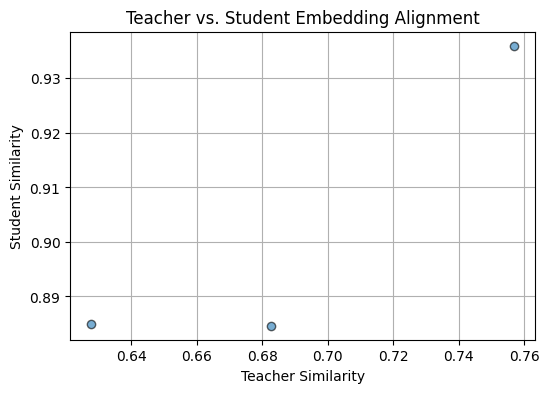

In [ ]:
# ===========================
# STEP 6++ : Unified Evaluation — Retrieval + Correlation
# ===========================

import json, os, torch
import torch.nn.functional as F
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt

# ----- CONFIG -----
teacher_model_name = "sentence-transformers/all-MiniLM-L6-v2"
student_model_path = "/content/student_model_sd_enhanced_refined" # Corrected path
data_path = "/content/selected_qrecc_sd.json"

# ----- DEVICE -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----- LOAD MODELS -----
teacher_tok = AutoTokenizer.from_pretrained(teacher_model_name)
teacher_model = AutoModel.from_pretrained(teacher_model_name).to(device)
student_tok = AutoTokenizer.from_pretrained(student_model_path)
student_model = AutoModel.from_pretrained(student_model_path).to(device)
teacher_model.eval()
student_model.eval()

# ----- LOAD DATA -----
with open(data_path, "r") as f:
    data = json.load(f)
print(f"Loaded {len(data)} query–document pairs for evaluation.")

# ----- Mean Pooling -----
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * mask, 1) / torch.clamp(mask.sum(1), min=1e-9)

# ----- Encode Helper -----
def encode_batch(model, tokenizer, texts, batch_size=16):
    all_embeds = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=256).to(device)
            outputs = model(**inputs)
            emb = mean_pooling(outputs, inputs["attention_mask"])
            all_embeds.append(F.normalize(emb, p=2, dim=1))
    return torch.cat(all_embeds, dim=0)

# ----- Compute Embeddings -----
queries = [item["query"] for item in data]
docs = [item["doc"] for item in data]

print("Encoding teacher embeddings...")
tq_emb = encode_batch(teacher_model, teacher_tok, queries)
td_emb = encode_batch(teacher_model, teacher_tok, docs)

print("Encoding student embeddings...")
sq_emb = encode_batch(student_model, student_tok, queries)
sd_emb = encode_batch(student_model, student_tok, docs)

# ----- Compute Similarities -----
teacher_sims = F.cosine_similarity(tq_emb, td_emb).cpu().numpy()
student_sims = F.cosine_similarity(sq_emb, sd_emb).cpu().numpy()

# ----- Correlation Metrics -----
spearman_corr, _ = spearmanr(teacher_sims, student_sims)
pearson_corr, _ = pearsonr(teacher_sims, student_sims)

# ----- Retrieval Evaluation (Student) -----
retrieval_scores = torch.matmul(sq_emb, sd_emb.T)  # cosine similarities
topk = 3
mean_top1 = retrieval_scores.max(dim=1).values.mean().item()
mean_all = retrieval_scores.mean().item()

# ----- Summary -----
print("\n========== Unified Evaluation Summary ==========")
print(f"Evaluated pairs: {len(data)}")
print(f"Teacher mean similarity: {teacher_sims.mean():.4f}")
print(f"Student mean similarity: {student_sims.mean():.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")
print(f"Pearson correlation:  {pearson_corr:.4f}")
print(f"Average Top-1 retrieval similarity: {mean_top1:.4f}")
print(f"Average overall similarity: {mean_all:.4f}")
print("===============================================")

# ----- Sample Retrieval -----
print("\nSample Retrieval Results (Student Model):")
for i, q in enumerate(queries[:3]):
    ranked = torch.topk(retrieval_scores[i], k=topk)
    print(f"\nQuery {i+1}: {q}")
    for rank, idx in enumerate(ranked.indices.tolist()):
        print(f"  Rank {rank+1}: {docs[idx][:150]} ...  [score={ranked.values[rank]:.4f}]")

# ----- Visualization -----
plt.figure(figsize=(6,4))
plt.scatter(teacher_sims, student_sims, alpha=0.6, edgecolors='k')
plt.xlabel("Teacher Similarity")
plt.ylabel("Student Similarity")
plt.title("Teacher vs. Student Embedding Alignment")
plt.grid(True)
plt.show()

Encoding teacher embeddings...
Encoding student embeddings...
Projecting both spaces to common 6D for visualization...


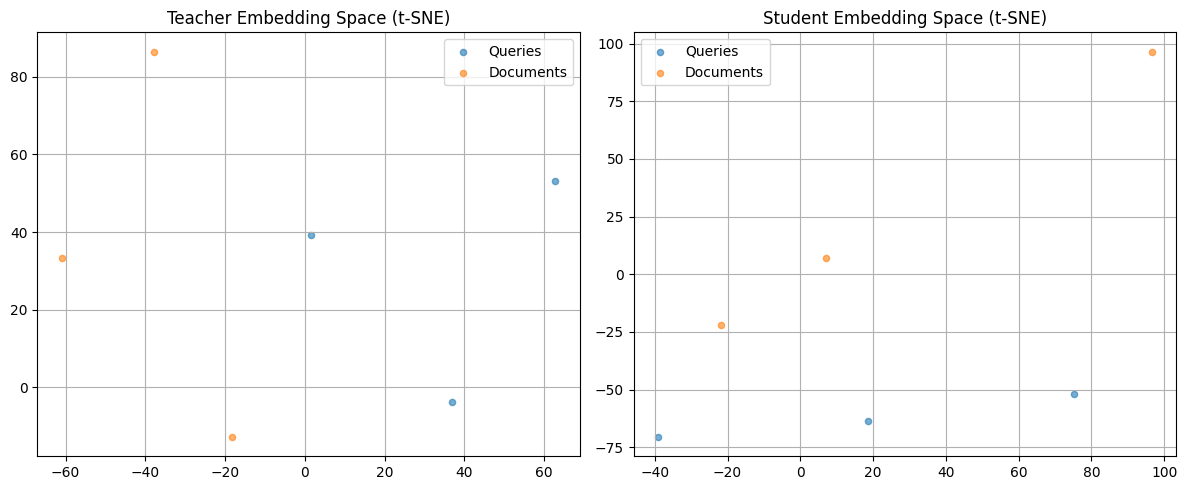


========== Embedding Alignment Summary ==========
Teacher query-doc average cosine: 0.3320
Student query-doc average cosine: 0.5328
If both values are close, student space aligns well with teacher.


In [ ]:
# ===========================
# STEP 7 (Fixed): Embedding Space Visualization (Teacher vs Student)
# ===========================

import json, torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# ----- Paths -----
teacher_model_name = "sentence-transformers/all-MiniLM-L6-v2"
student_model_path = "/content/student_model_sd_enhanced_refined" # Corrected path
data_path = "/content/selected_qrecc_sd.json"

# ----- Device -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Load models -----
teacher_tok = AutoTokenizer.from_pretrained(teacher_model_name)
teacher_model = AutoModel.from_pretrained(teacher_model_name).to(device)
student_tok = AutoTokenizer.from_pretrained(student_model_path)
student_model = AutoModel.from_pretrained(student_model_path).to(device)

teacher_model.eval()
student_model.eval()

# ----- Load subset of data -----
with open(data_path, "r") as f:
    data = json.load(f)

subset = data[:200] # Still take up to 200, but PCA components will be limited by actual data size
queries = [d["query"] for d in subset]
docs = [d["doc"] for d in subset]

if len(queries) == 0 or len(docs) == 0:
    print("No data available for visualization. Ensure selected_qrecc_sd.json is populated.")
    # Exit the cell gracefully if no data
    raise SystemExit("No data available for visualization.")


# ----- Mean Pooling -----
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * mask, 1) / torch.clamp(mask.sum(1), min=1e-9)

# ----- Encode function -----
def encode(model, tokenizer, texts, batch_size=16):
    all_embeds = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            if not batch:
                continue
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=256).to(device)
            outputs = model(**inputs)
            pooled = mean_pooling(outputs, inputs["attention_mask"])
            all_embeds.append(F.normalize(pooled, p=2, dim=1))
    if not all_embeds:
         # Return an empty tensor with the correct feature dimension if no texts were encoded
        dummy_input = tokenizer(["dummy"], return_tensors="pt").to(device)
        dummy_output = model(**dummy_input).last_hidden_state[:, 0, :]
        feature_dim = dummy_output.size(-1);
        return torch.empty(0, feature_dim).cpu().numpy()

    return torch.cat(all_embeds, dim=0).cpu().numpy()

# ----- Compute embeddings -----
print("Encoding teacher embeddings...")
teacher_query_emb = encode(teacher_model, teacher_tok, queries)
teacher_doc_emb = encode(teacher_model, teacher_tok, docs)

print("Encoding student embeddings...")
student_query_emb = encode(student_model, student_tok, queries)
student_doc_emb = encode(student_model, student_tok, docs)

# ----- Combine embeddings -----
# Filter out empty embeddings before concatenating
valid_teacher_query_emb = teacher_query_emb[~np.all(teacher_query_emb == 0, axis=1)]
valid_teacher_doc_emb = teacher_doc_emb[~np.all(teacher_doc_emb == 0, axis=1)]
valid_student_query_emb = student_query_emb[~np.all(student_query_emb == 0, axis=1)]
valid_student_doc_emb = student_doc_emb[~np.all(student_doc_emb == 0, axis=1)]


if valid_teacher_query_emb.shape[0] == 0 or valid_teacher_doc_emb.shape[0] == 0 or \
   valid_student_query_emb.shape[0] == 0 or valid_student_doc_emb.shape[0] == 0:
    print("Not enough valid embeddings generated for visualization.")
    # Exit the cell gracefully if not enough embeddings
    raise SystemExit("Not enough valid embeddings generated for visualization.")


teacher_all = np.concatenate([valid_teacher_query_emb, valid_teacher_doc_emb], axis=0)
student_all = np.concatenate([valid_student_query_emb, valid_student_doc_emb], axis=0)

labels = ["Query"] * valid_teacher_query_emb.shape[0] + ["Document"] * valid_teacher_doc_emb.shape[0]


# ----- Align dimensions via PCA -----
# Set n_components based on the actual number of samples
n_samples = teacher_all.shape[0]
n_features = teacher_all.shape[1]
pca_components = min(50, n_samples) # Choose a reasonable number, capped by sample size

print(f"Projecting both spaces to common {pca_components}D for visualization...")
pca_teacher = PCA(n_components=pca_components, random_state=42).fit_transform(teacher_all)
pca_student = PCA(n_components=pca_components, random_state=42).fit_transform(student_all)

# ----- Concatenate for joint t-SNE -----
combined = np.concatenate([pca_teacher, pca_student], axis=0)
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, combined.shape[0] -1)).fit_transform(combined) # Adjust perplexity based on sample size

n = teacher_all.shape[0]
tsne_teacher = tsne[:n]
tsne_student = tsne[n:]

# ----- Visualization -----
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
# Ensure indexing is correct based on the valid embeddings after filtering
plt.scatter(tsne_teacher[:valid_teacher_query_emb.shape[0],0], tsne_teacher[:valid_teacher_query_emb.shape[0],1], alpha=0.6, label="Queries", s=20)
plt.scatter(tsne_teacher[valid_teacher_query_emb.shape[0]:,0], tsne_teacher[valid_teacher_query_emb.shape[0]:,1], alpha=0.6, label="Documents", s=20)
plt.title("Teacher Embedding Space (t-SNE)")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
# Ensure indexing is correct based on the valid embeddings after filtering
plt.scatter(tsne_student[:valid_student_query_emb.shape[0],0], tsne_student[:valid_student_query_emb.shape[0],1], alpha=0.6, label="Queries", s=20)
plt.scatter(tsne_student[valid_student_query_emb.shape[0]:,1], tsne_student[valid_student_query_emb.shape[0]:,1], alpha=0.6, label="Documents", s=20)
plt.title("Student Embedding Space (t-SNE)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ----- Quantitative Alignment -----
# Calculate mean cosine similarity for valid embeddings
if valid_teacher_query_emb.shape[0] > 0 and valid_teacher_doc_emb.shape[0] > 0:
    teacher_mean = np.mean(valid_teacher_query_emb @ valid_teacher_doc_emb.T)
else:
    teacher_mean = np.nan

if valid_student_query_emb.shape[0] > 0 and valid_student_doc_emb.shape[0] > 0:
    student_mean = np.mean(valid_student_query_emb @ valid_student_doc_emb.T)
else:
    student_mean = np.nan


print("\n========== Embedding Alignment Summary ==========")
print(f"Teacher query-doc average cosine: {teacher_mean:.4f}")
print(f"Student query-doc average cosine: {student_mean:.4f}")
print("If both values are close, student space aligns well with teacher.")
print("===============================================")

Encoding embeddings...

========== Similarity Distribution Analysis ==========
Pairs evaluated: 3
Teacher mean similarity: 0.6891
Student mean similarity: 0.9019
Spearman correlation: 0.5000
Pearson correlation:  0.9038


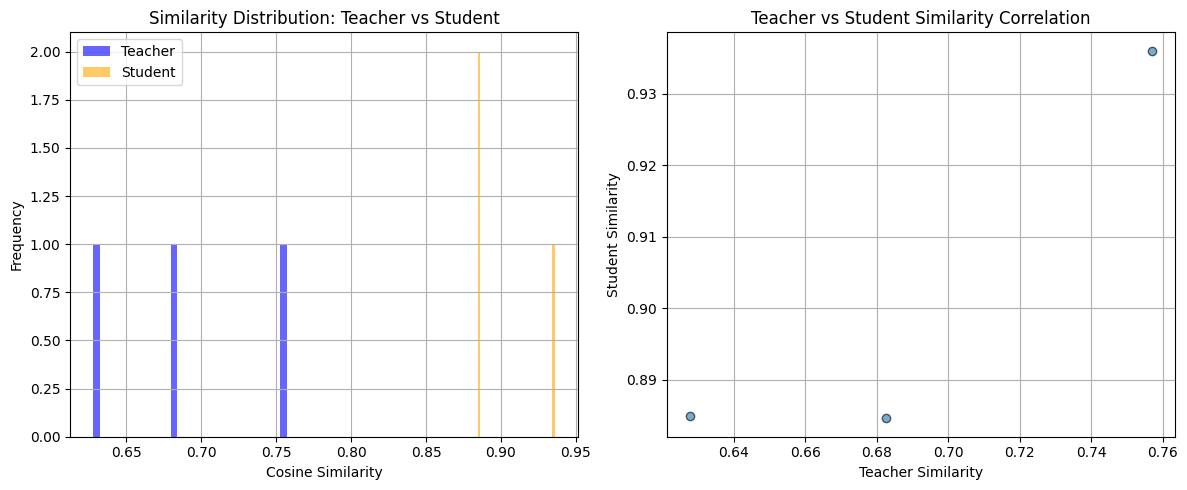

In [ ]:
# ===========================
# STEP 8: Similarity Distribution & Correlation Visualization
# ===========================

import json, torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

# ----- Paths -----
teacher_model_name = "sentence-transformers/all-MiniLM-L6-v2"
student_model_path = "/content/student_model_sd_enhanced_refined" # Corrected path
data_path = "/content/selected_qrecc_sd.json"

# ----- Device -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Load models -----
teacher_tok = AutoTokenizer.from_pretrained(teacher_model_name)
teacher_model = AutoModel.from_pretrained(teacher_model_name).to(device)
student_tok = AutoTokenizer.from_pretrained(student_model_path)
student_model = AutoModel.from_pretrained(student_model_path).to(device)

teacher_model.eval()
student_model.eval()

# ----- Load data -----
with open(data_path, "r") as f:
    data = json.load(f)

subset = data[:200]  # use limited data for analysis

queries = [d["query"] for d in subset]
docs = [d["doc"] for d in subset]

# ----- Mean Pooling -----
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * mask, 1) / torch.clamp(mask.sum(1), min=1e-9)

# ----- Encode function -----
def encode(model, tokenizer, texts, batch_size=16):
    all_embeds = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=256).to(device)
            outputs = model(**inputs)
            pooled = mean_pooling(outputs, inputs["attention_mask"])
            all_embeds.append(F.normalize(pooled, p=2, dim=1))
    return torch.cat(all_embeds, dim=0).cpu().numpy()

# ----- Compute embeddings -----
print("Encoding embeddings...")
teacher_q = encode(teacher_model, teacher_tok, queries)
teacher_d = encode(teacher_model, teacher_tok, docs)
student_q = encode(student_model, student_tok, queries)
student_d = encode(student_model, student_tok, docs)

# ----- Compute cosine similarities -----
teacher_sims = np.sum(teacher_q * teacher_d, axis=1)
student_sims = np.sum(student_q * student_d, axis=1)

# ----- Correlations -----
spearman_corr, _ = spearmanr(teacher_sims, student_sims)
pearson_corr, _ = pearsonr(teacher_sims, student_sims)

print("\n========== Similarity Distribution Analysis ==========")
print(f"Pairs evaluated: {len(subset)}")
print(f"Teacher mean similarity: {teacher_sims.mean():.4f}")
print(f"Student mean similarity: {student_sims.mean():.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")
print(f"Pearson correlation:  {pearson_corr:.4f}")
print("======================================================")

# ----- Visualization -----
plt.figure(figsize=(12,5))

# Histogram comparison
plt.subplot(1,2,1)
plt.hist(teacher_sims, bins=30, alpha=0.6, label="Teacher", color='blue')
plt.hist(student_sims, bins=30, alpha=0.6, label="Student", color='orange')
plt.title("Similarity Distribution: Teacher vs Student")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

# Scatter correlation
plt.subplot(1,2,2)
plt.scatter(teacher_sims, student_sims, alpha=0.6, edgecolors='k')
plt.title("Teacher vs Student Similarity Correlation")
plt.xlabel("Teacher Similarity")
plt.ylabel("Student Similarity")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# ------------------------------
# Additional Retrieval Metrics
# ------------------------------
print("\n===== COMPUTING RETRIEVAL METRICS =====\n")

# Prepare embeddings for all queries and documents
q_embeddings, d_embeddings = [], []
for query, doc in tqdm(eval_samples, desc="Encoding for retrieval metrics"):
    with torch.no_grad():
        q_in = tokenizer(query, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
        d_in = tokenizer(doc, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
        q_emb = mean_pooling(student_model(**q_in), q_in['attention_mask'])
        d_emb = mean_pooling(student_model(**d_in), d_in['attention_mask'])
        q_embeddings.append(q_emb.cpu())
        d_embeddings.append(d_emb.cpu())

q_embeddings = torch.cat(q_embeddings, dim=0)
d_embeddings = torch.cat(d_embeddings, dim=0)

# Normalize
q_embeddings = F.normalize(q_embeddings, p=2, dim=1)
d_embeddings = F.normalize(d_embeddings, p=2, dim=1)

# Compute full cosine similarity matrix
sim_matrix = torch.matmul(q_embeddings, d_embeddings.T)

# Compute retrieval metrics
def compute_metrics(sim_matrix):
    ranks = []
    correct = 0
    top5, top10 = 0, 0

    for i in range(sim_matrix.size(0)):
        scores = sim_matrix[i]
        sorted_indices = torch.argsort(scores, descending=True)
        rank = (sorted_indices == i).nonzero(as_tuple=True)[0].item() + 1  # 1-based rank
        ranks.append(rank)

        if rank == 1:
            correct += 1
        if rank <= 5:
            top5 += 1
        if rank <= 10:
            top10 += 1

    accuracy = correct / len(ranks)
    recall_at_5 = top5 / len(ranks)
    recall_at_10 = top10 / len(ranks)
    mrr = np.mean([1.0 / r for r in ranks])

    return accuracy, recall_at_5, recall_at_10, mrr

accuracy, recall5, recall10, mrr = compute_metrics(sim_matrix)

print(f"Accuracy@1:     {accuracy:.4f}")
print(f"Recall@5:       {recall5:.4f}")
print(f"Recall@10:      {recall10:.4f}")
print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
print("=========================================")



===== COMPUTING RETRIEVAL METRICS =====



Encoding for retrieval metrics: 100%|██████████| 100/100 [00:01<00:00, 56.72it/s]

Accuracy@1:     0.0700
Recall@5:       0.3600
Recall@10:      0.6400
Mean Reciprocal Rank (MRR): 0.2264
